
# 2. Données

Le jeu de données peut être téléchargé depuis : [https://www.kaggle.com/ntnu-testimon/paysim1](https://www.kaggle.com/ntnu-testimon/paysim1)

Ce jeu de données contient des transactions d'argent mobile qui ont été générées avec le simulateur PaySim. La simulation était basée sur un échantillon de transactions réelles collectées par une entreprise qui est le fournisseur du service financier mobile actuellement en cours dans plus de 14 pays à travers le monde. Les données sont un ensemble de journaux financiers d'un mois d'un service d'argent mobile mis en place dans un pays africain.

Les données sont regroupées dans un fichier CSV. Un exemple de ligne d'échantillon :
\`1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0\`

Le jeu de données contient (suivant l'exemple ci-dessus) :

- **step** - représente une unité de temps dans le monde réel. Dans ce cas, 1 étape équivaut à 1 heure de temps. Total des étapes : 744 (simulation de 30 jours).
- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT et TRANSFER.
- **amount** - montant de la transaction en monnaie locale.
- **nameOrig** - client ayant initié la transaction.
- **oldbalanceOrg** - solde initial avant la transaction.
- **newbalanceOrig** - nouveau solde après la transaction.
- **nameDest** - client destinataire de la transaction.
- **oldbalanceDest** - solde initial du destinataire avant la transaction. Remarque : aucune information n'est disponible pour les clients dont le nom commence par M (commerçants).
- **newbalanceDest** - nouveau solde du destinataire après la transaction. Remarque : aucune information n'est disponible pour les clients dont le nom commence par M (commerçants).
- **isFraud** - Il s'agit des transactions effectuées par des agents frauduleux dans la simulation. Dans ce jeu de données spécifique, le comportement frauduleux des agents vise à tirer profit en prenant le contrôle des comptes des clients et en essayant de vider les fonds en les transférant vers un autre compte, puis en les retirant du système.
- **isFlaggedFraud** - Le modèle commercial vise à contrôler les transferts massifs d'un compte à un autre et signale les tentatives illégales. Une tentative illégale dans ce jeu de données est une tentative de transférer plus de 200 000 lors d'une seule transaction.


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

# Model evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

: 

# Load and Exploration Data

In [7]:
df = pd.read_csv("data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
dt = df.copy()

In [5]:
dt.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
data = df.copy()

In [12]:
#Nombre total de transactions
total_transactions = len(data)


In [13]:
# Montant total des transactions
total_amount = data['amount'].sum()

In [14]:
# Fréquence des types de transactions
transaction_types_frequency = data['type'].value_counts()

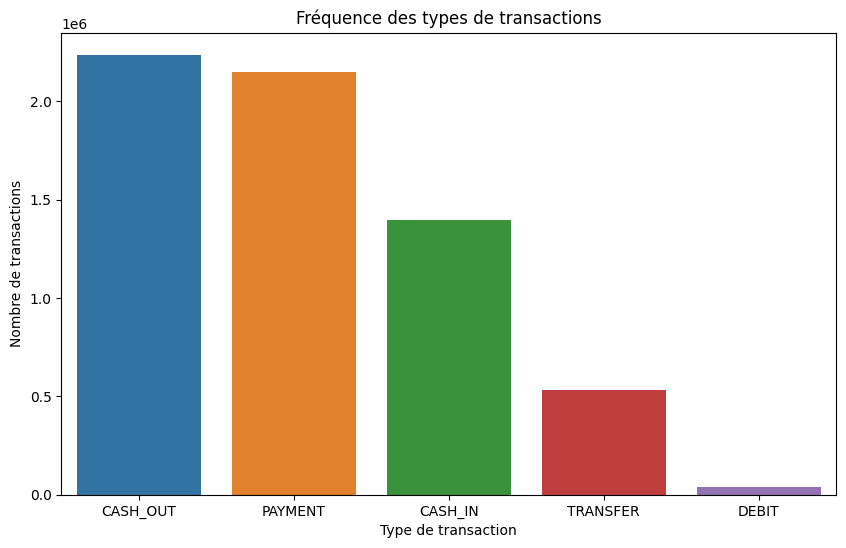

In [39]:

#  Fréquence des types de transactions avec visualisation graphique
transaction_types_frequency = data['type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=transaction_types_frequency.index, y=transaction_types_frequency.values)
plt.title('Fréquence des types de transactions')
plt.xlabel('Type de transaction')
plt.ylabel('Nombre de transactions')
plt.show()

In [15]:
# Analyse du solde avant et après la transaction
data['balance_change'] = data['newbalanceOrig'] - data['oldbalanceOrg']

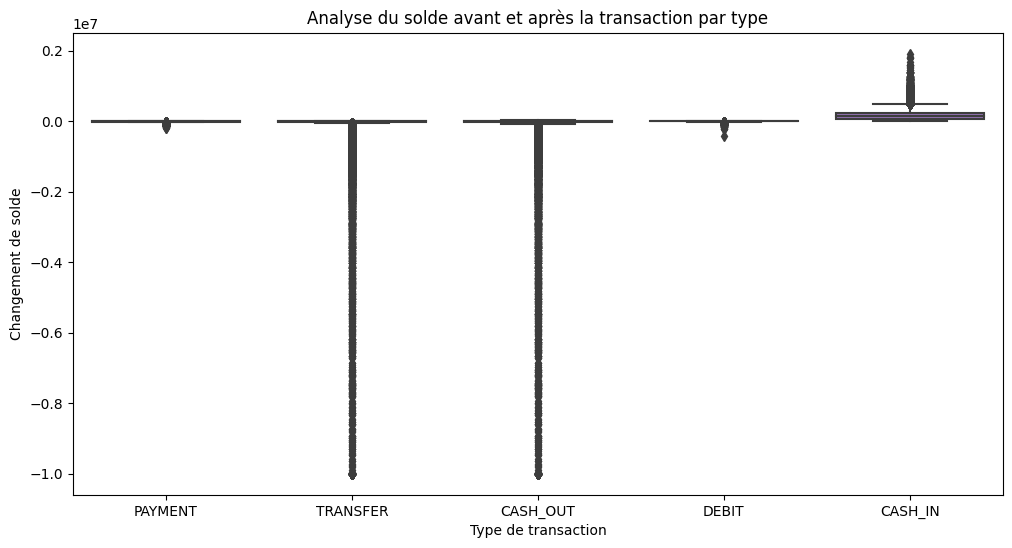

In [41]:

# Analyse du solde avant et après la transaction avec visualisation graphique
data['balance_change'] = data['newbalanceOrig'] - data['oldbalanceOrg']
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='balance_change', data=data)
plt.title('Analyse du solde avant et après la transaction par type')
plt.xlabel('Type de transaction')
plt.ylabel('Changement de solde')
plt.show()

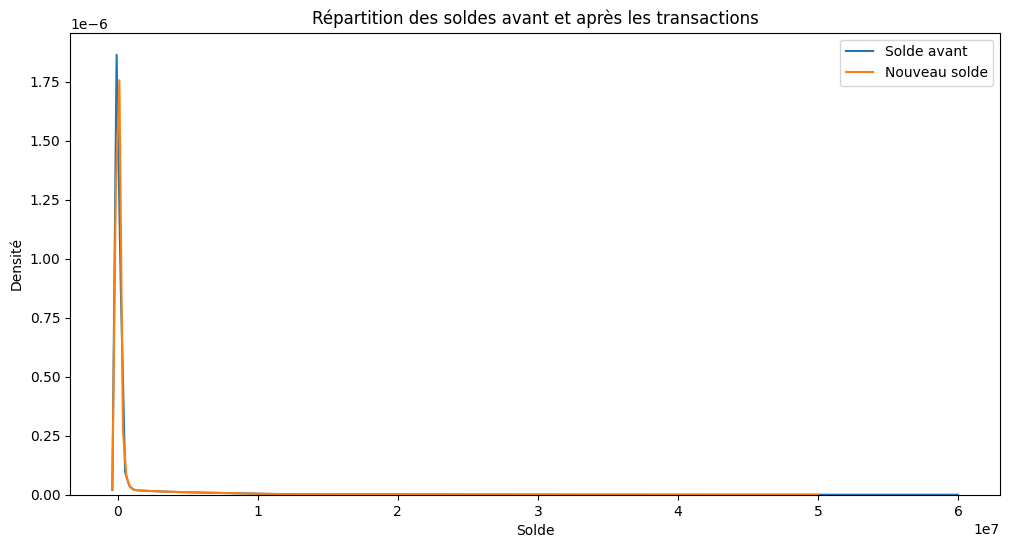

In [45]:
#Répartition des soldes avant et après les transactions avec visualisation graphique
plt.figure(figsize=(12, 6))
sns.kdeplot(data['oldbalanceOrg'], label='Solde avant')
sns.kdeplot(data['newbalanceOrig'], label='Nouveau solde')
plt.title('Répartition des soldes avant et après les transactions')
plt.xlabel('Solde')
plt.ylabel('Densité')
plt.legend()
plt.show()

In [16]:
#  Nombre de transactions frauduleuses
fraudulent_transactions = data[data['isFraud'] == 1]
num_fraudulent_transactions = len(fraudulent_transactions)

In [17]:
# Pourcentage de transactions frauduleuses
percentage_fraudulent_transactions = (num_fraudulent_transactions / total_transactions) * 100


In [18]:
# Fréquence des transferts illégaux signalés
flagged_fraud_transactions = data[data['isFlaggedFraud'] == 1]
num_flagged_fraud_transactions = len(flagged_fraud_transactions)
num_flagged_fraud_transactions 


16

In [19]:
# Montant moyen des transactions par type
average_amount_by_type = data.groupby('type')['amount'].mean()

In [20]:

# Analyse de la fraude par type de transaction
fraud_by_type = fraudulent_transactions['type'].value_counts()

In [21]:

# Taux de fraude par unité de temps
fraud_rate_by_step = fraudulent_transactions['step'].value_counts() / total_transactions



In [22]:

# Analyse des transactions de commerçants
merchant_transactions = data[data['nameDest'].str.startswith('M')]
num_merchant_transactions = len(merchant_transactions)


 le pourcentage de transactions frauduleuses qui ont été correctement signalées (isFlaggedFraud).

In [23]:
correctly_flagged_rate = len(flagged_fraud_transactions) / num_fraudulent_transactions
print(" Taux de transactions frauduleuses signalées correctement =", correctly_flagged_rate)


 Taux de transactions frauduleuses signalées correctement = 0.0019481310118105442


##### Analyse du comportement des clients frauduleuse 

In [26]:
fraudulent_clients_stats = fraudulent_transactions.groupby('nameOrig').agg(
    count_amount=('amount', 'count'),
    mean_amount=('amount', 'mean'),
    mean_balance_change=('balance_change', 'mean')
)
fraudulent_clients_stats['count_amount'].unique()

array([1], dtype=int64)

In [27]:
fraudulent_clients_stats

,count_amount,mean_amount,mean_balance_change
nameOrig,,,
C1000036340,1,253648.68,-253648.68
C1000086512,1,33676.59,-33676.59
C1000331499,1,2016790.84,-2016790.84
C1000484178,1,3018810.85,-3018810.85
C1000513158,1,40388.58,-40388.58
...,...,...,...
C998715487,1,634385.97,-634385.97
C998785780,1,606920.11,-606920.11
C998822926,1,450458.78,-450458.78


L'analyse que l'on peut faire à partir des résultats montre que, en moyenne, les clients frauduleux transfèrent ou retirent des montants équivalents à leur solde, et chacun d'entre eux effectue une seule transaction.

 le temps moyen écoulé entre la création d'une transaction frauduleuse et sa détection.

In [29]:
fraud_detection_time = (fraudulent_transactions['step'] - fraudulent_transactions['step'].min()).mean()
print("Temps moyen de détection des fraudes =", fraud_detection_time)


Temps moyen de détection des fraudes = 367.4138560818215


 la moyenne des montants pour les transactions marquées comme frauduleuses.

In [30]:
average_fraudulent_amount = fraudulent_transactions['amount'].mean()
print(" Montant moyen de transactions frauduleuses =", average_fraudulent_amount)


 Montant moyen de transactions frauduleuses = 1467967.299140387


 les heures de la journée où les transactions sont les plus fréquentes.

In [31]:
peak_hours = data.groupby('step')['step'].count().idxmax()
print(" Heures de pointe =", peak_hours)


 Heures de pointe = 19


la fréquence à laquelle les soldes des comptes sont renouvelés.

In [32]:
balance_renewal_rate = (data['newbalanceOrig'] > data['oldbalanceOrg']).sum() / total_transactions
print("Taux de renouvellement des soldes =", balance_renewal_rate)


Taux de renouvellement des soldes = 0.2199177382902012


les catégories de destinataires les plus courantes dans les transactions.

In [33]:
top_destination_categories = data['nameDest'].apply(lambda x: x[0] if x[0] != 'M' else 'Marchant').value_counts()
print("Catégories de destinataires les plus fréquentes :\n", top_destination_categories)


Catégories de destinataires les plus fréquentes :
 nameDest
C           4211125
Marchant    2151495
Name: count, dtype: int64


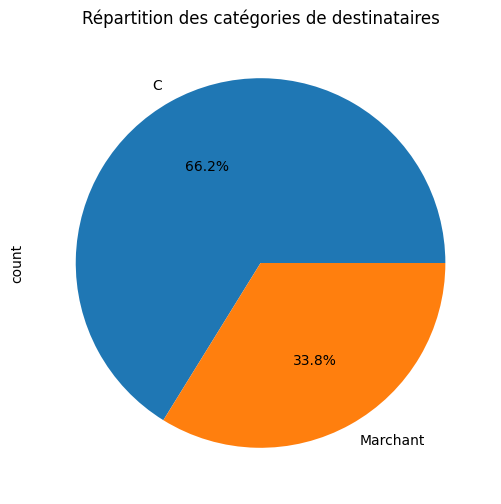

In [43]:
# Analyse des catégories de destinataires les plus fréquentes avec visualisation graphique
top_destination_categories = data['nameDest'].apply(lambda x: x[0] if x[0] != 'M' else 'Marchant').value_counts()
plt.figure(figsize=(10, 6))
top_destination_categories.plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des catégories de destinataires')
plt.show()

In [37]:
average_transaction_duration = data.groupby('type')['step'].diff().mean()
print(" Durée moyenne des transactions =", average_transaction_duration)


 Durée moyenne des transactions = 0.0005713059803241278


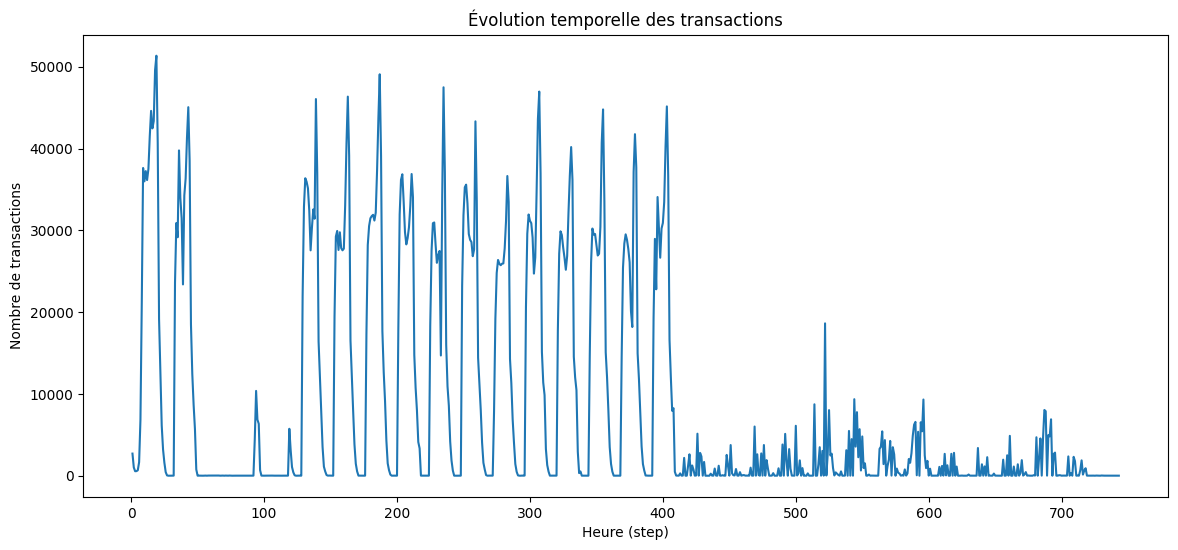

In [44]:
#  Évolution temporelle des transactions avec visualisation graphique
transactions_by_time = data.groupby('step')['step'].count()
plt.figure(figsize=(14, 6))
transactions_by_time.plot(kind='line')
plt.title('Évolution temporelle des transactions')
plt.xlabel('Heure (step)')
plt.ylabel('Nombre de transactions')
plt.show()

#### etude sur le variable montant 

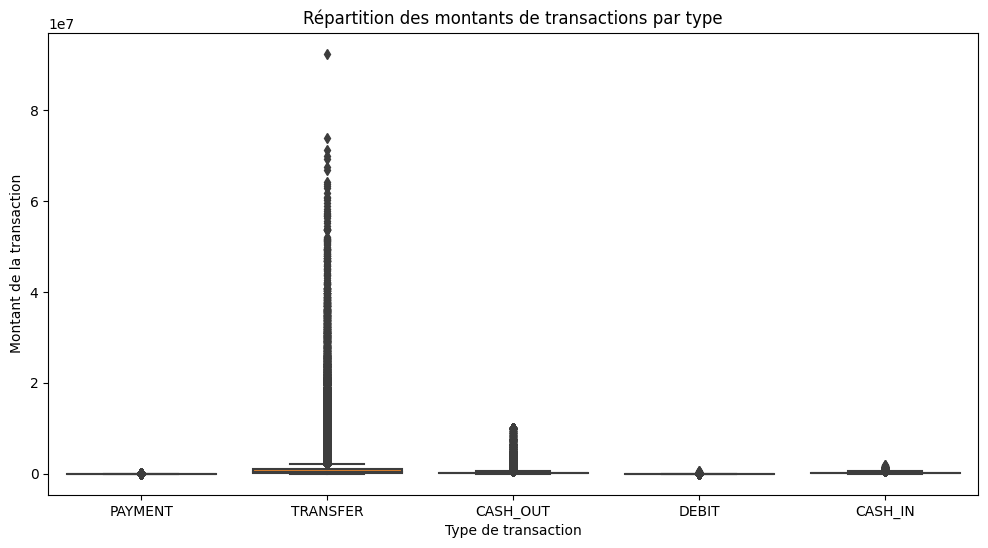

In [46]:
#  Répartition des montants de transactions par type avec visualisation graphique
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='amount', data=data)
plt.title('Répartition des montants de transactions par type')
plt.xlabel('Type de transaction')
plt.ylabel('Montant de la transaction')
plt.show()


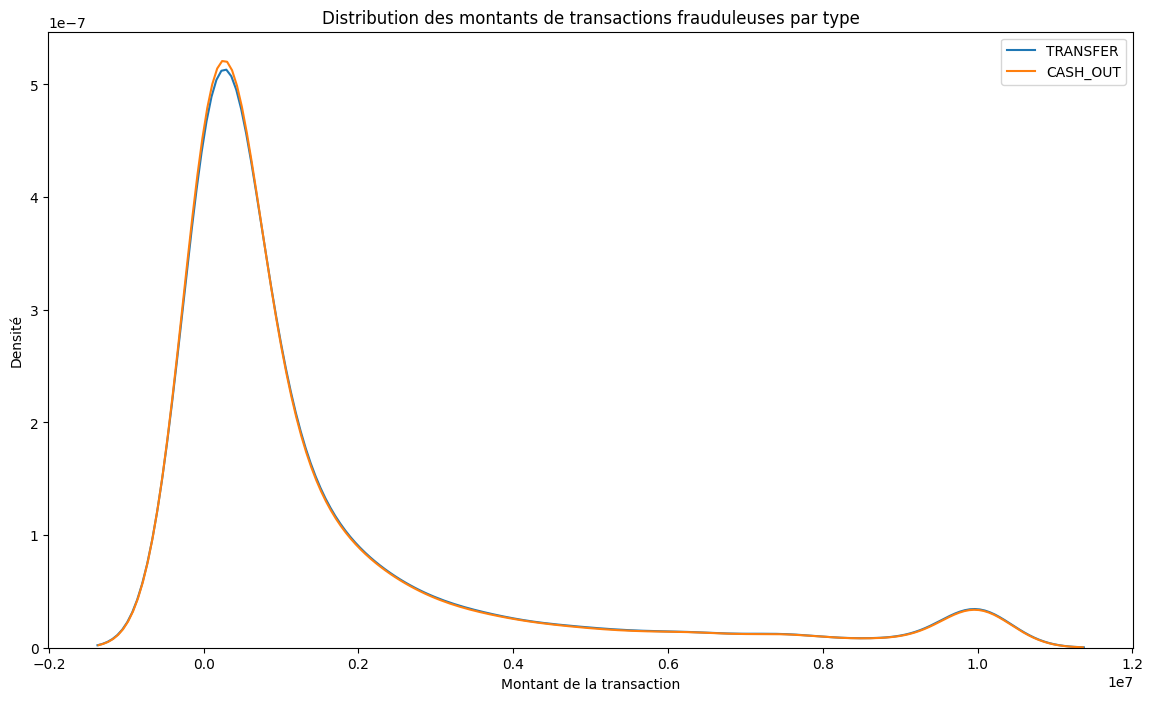

In [47]:
# Distribution des montants de transactions frauduleuses par type avec visualisation graphique
fraudulent_types = fraudulent_transactions['type'].unique()
plt.figure(figsize=(14, 8))

for f_type in fraudulent_types:
    sns.kdeplot(fraudulent_transactions[fraudulent_transactions['type'] == f_type]['amount'], label=f_type)

plt.title('Distribution des montants de transactions frauduleuses par type')
plt.xlabel('Montant de la transaction')
plt.ylabel('Densité')
plt.legend()
plt.show()


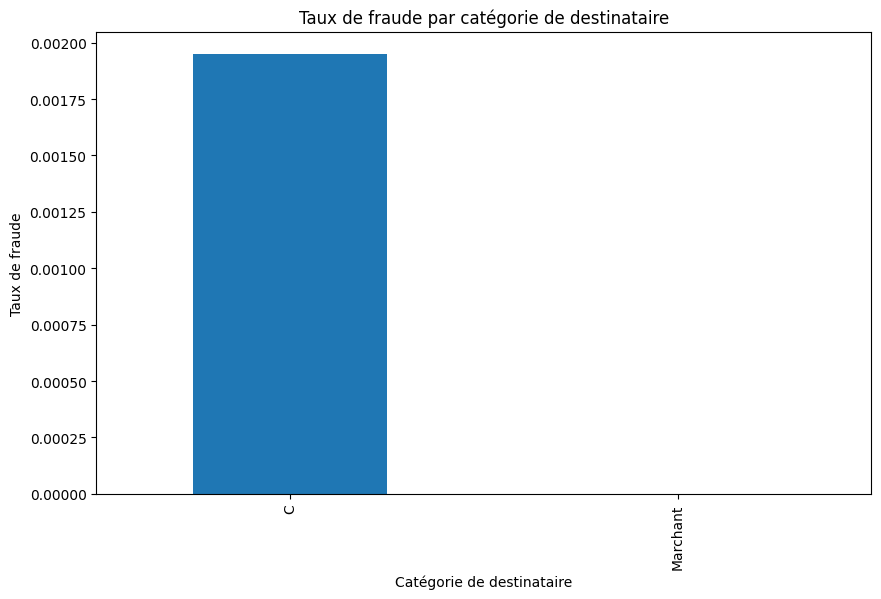

In [48]:
# Taux de fraude par catégorie de destinataire avec visualisation graphique
data['dest_category'] = data['nameDest'].apply(lambda x: x[0] if x[0] != 'M' else 'Marchant')
fraud_rate_by_dest_category = data.groupby('dest_category')['isFraud'].mean()
plt.figure(figsize=(10, 6))
fraud_rate_by_dest_category.plot(kind='bar')
plt.title('Taux de fraude par catégorie de destinataire')
plt.xlabel('Catégorie de destinataire')
plt.ylabel('Taux de fraude')
plt.show()


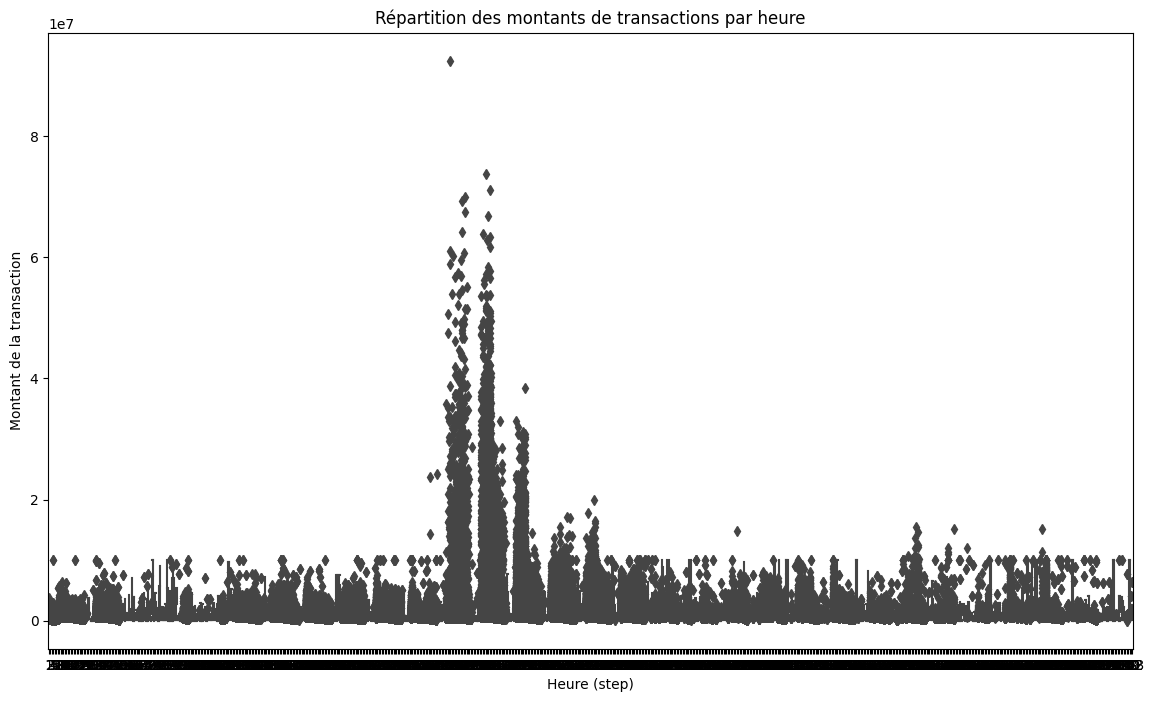

In [49]:
#  Répartition des montants de transactions par heure avec visualisation graphique
plt.figure(figsize=(14, 8))
sns.boxplot(x='step', y='amount', data=data)
plt.title('Répartition des montants de transactions par heure')
plt.xlabel('Heure (step)')
plt.ylabel('Montant de la transaction')
plt.show()


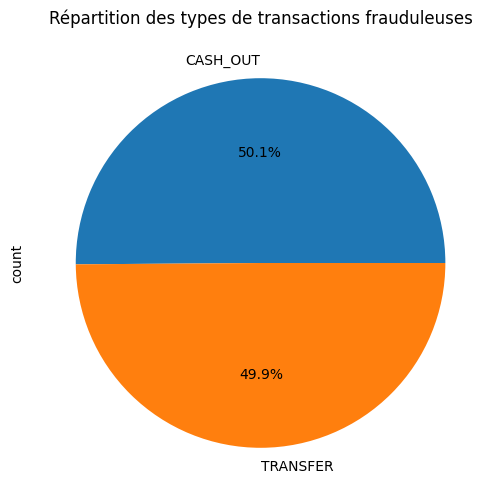

In [50]:
#  Diagramme en secteurs des types de transactions frauduleuses 
fraud_by_type = fraudulent_transactions['type'].value_counts()
plt.figure(figsize=(10, 6))
fraud_by_type.plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des types de transactions frauduleuses')
plt.show()


In [100]:

date_debut = pd.to_datetime('2023-02-01')  # la date de debut 

# Convertir step en heures en ajoutant la date de début
data['timestamp'] = date_debut + pd.to_timedelta(data['step'], unit='h')

# Extraire le jour de la semaine et ajouter une colonne 'jour_de_la_semaine'
data['jour_de_la_semaine'] = data['timestamp'].dt.day_name()

# Visualisation du résultat
#print(data[['step', 'timestamp', 'jour_de_la_semaine']].head())

data['timestamp'].unique()

<DatetimeArray>
['2023-02-01 01:00:00', '2023-02-01 02:00:00', '2023-02-01 03:00:00',
 '2023-02-01 04:00:00', '2023-02-01 05:00:00', '2023-02-01 06:00:00',
 '2023-02-01 07:00:00', '2023-02-01 08:00:00', '2023-02-01 09:00:00',
 '2023-02-01 10:00:00',
 ...
 '2023-03-03 14:00:00', '2023-03-03 15:00:00', '2023-03-03 16:00:00',
 '2023-03-03 17:00:00', '2023-03-03 18:00:00', '2023-03-03 19:00:00',
 '2023-03-03 20:00:00', '2023-03-03 21:00:00', '2023-03-03 22:00:00',
 '2023-03-03 23:00:00']
Length: 743, dtype: datetime64[ns]

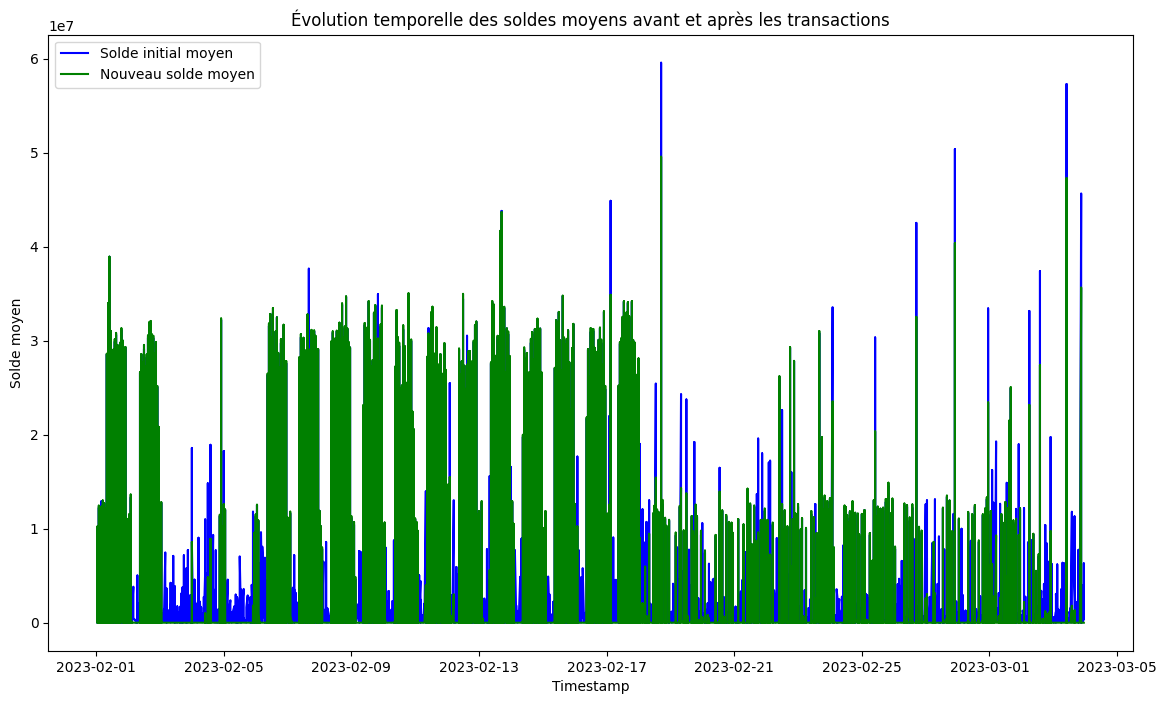

In [53]:

# Évolution temporelle des soldes moyens avant et après les transactions 
plt.figure(figsize=(14, 8))
plt.plot(data['timestamp'], data['oldbalanceOrg'], label='Solde initial moyen', linestyle='-', color='b')
plt.plot(data['timestamp'], data['newbalanceOrig'], label='Nouveau solde moyen', linestyle='-', color='g')
plt.title('Évolution temporelle des soldes moyens avant et après les transactions')
plt.xlabel('Timestamp')
plt.ylabel('Solde moyen')
plt.legend()
plt.show()

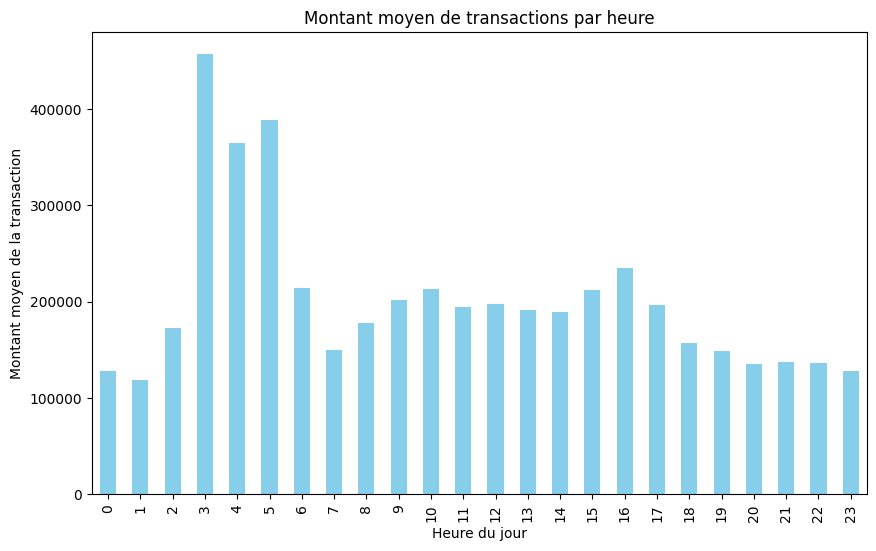

In [54]:
# Montant moyen de transactions par heure avec visualisation graphique
average_amount_by_hour = data.groupby(data['timestamp'].dt.hour)['amount'].mean()
plt.figure(figsize=(10, 6))
average_amount_by_hour.plot(kind='bar', color='skyblue')
plt.title('Montant moyen de transactions par heure')
plt.xlabel('Heure du jour')
plt.ylabel('Montant moyen de la transaction')
plt.show()


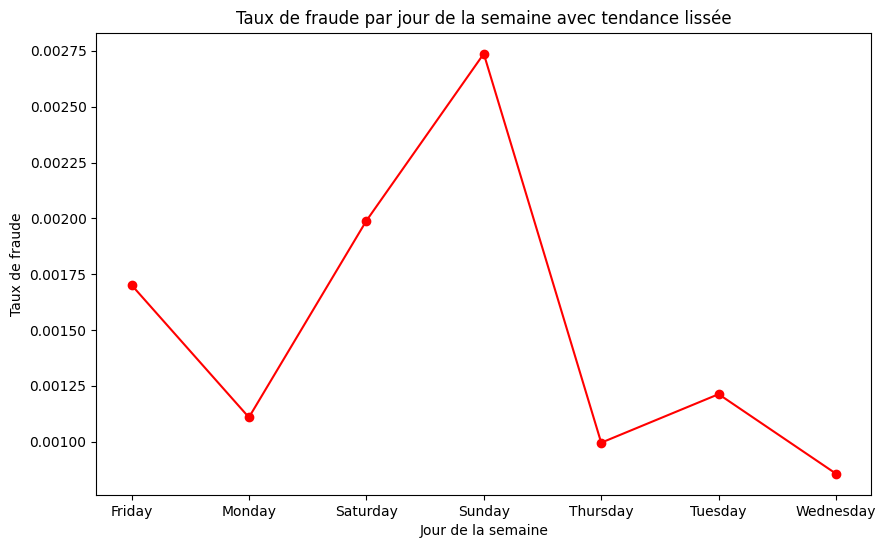

In [55]:
# Taux de fraude par jour de la semaine avec tendance lissée
fraud_rate_by_weekday = data.groupby(data['timestamp'].dt.day_name())['isFraud'].mean()
plt.figure(figsize=(10, 6))
fraud_rate_by_weekday.plot(kind='line', marker='o', color='red')
plt.title('Taux de fraude par jour de la semaine avec tendance lissée')
plt.xlabel('Jour de la semaine')
plt.ylabel('Taux de fraude')
plt.show()


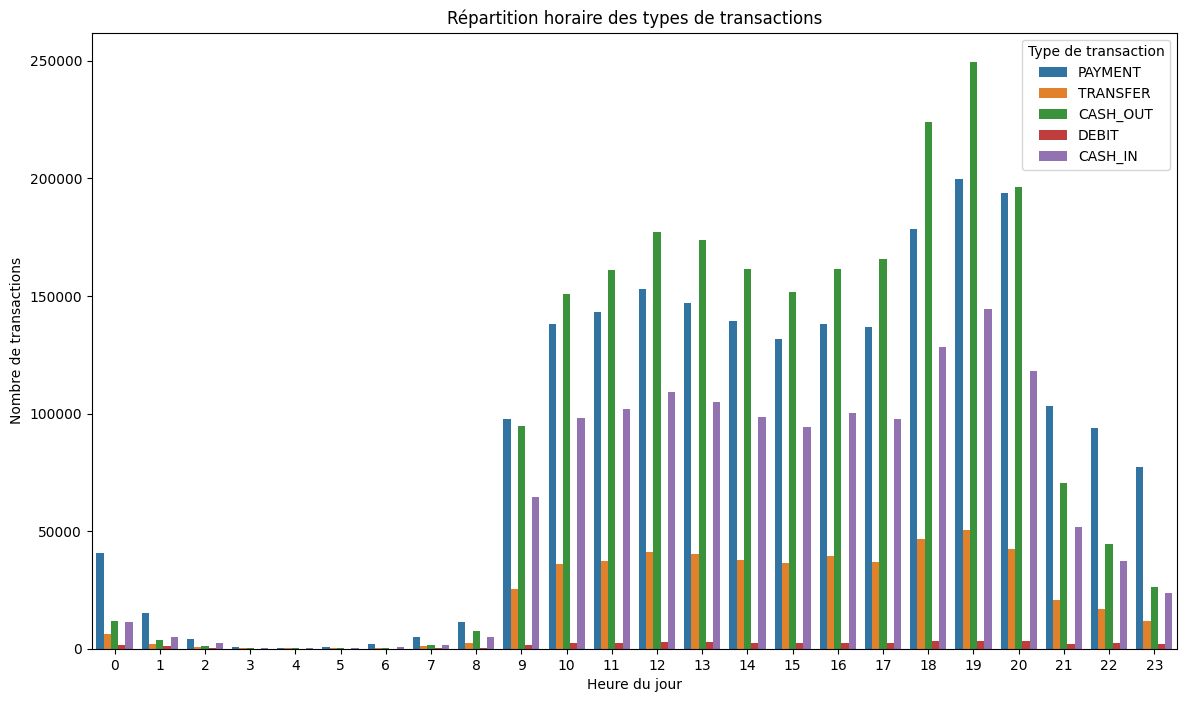

In [57]:
# Analyse des variations horaires des types de transactions 
plt.figure(figsize=(14, 8))
sns.countplot(x=data['timestamp'].dt.hour, hue=data['type'], data=data)
plt.title('Répartition horaire des types de transactions')
plt.xlabel('Heure du jour')
plt.ylabel('Nombre de transactions')
plt.legend(title='Type de transaction')
plt.show()


 les heures de la journée où les transactions sont les plus fréquentes se situe entre 18h et 20h avec un pic en 19h. Autre constact les transaction débute entre 7h et 8h et se termine entre 0 et 1h du matin

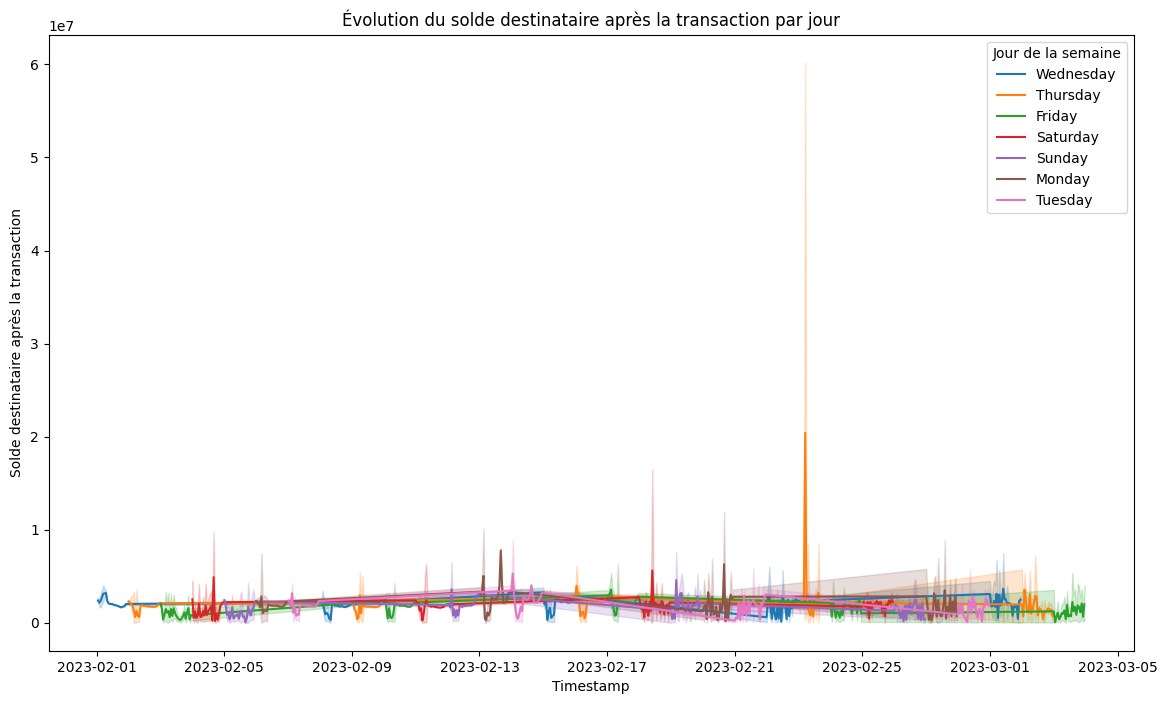

In [101]:
#  Évolution du solde destinataire après la transaction
plt.figure(figsize=(14, 8))
sns.lineplot(x='timestamp', y='newbalanceDest', hue='jour_de_la_semaine', data=data)
plt.title("Évolution du solde destinataire après la transaction par jour")
plt.xlabel("Timestamp")
plt.ylabel("Solde destinataire après la transaction")
plt.legend(title='Jour de la semaine')
plt.show()


In [60]:
fraudulent_transactions = data[data['isFraud']==1]
fraudulent_transactions

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_change,dest_category,timestamp,jour_de_la_semaine
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,-181.00,C,2023-02-01 01:00:00,Wednesday
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,-181.00,C,2023-02-01 01:00:00,Wednesday
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0,-2806.00,C,2023-02-01 01:00:00,Wednesday
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0,-2806.00,C,2023-02-01 01:00:00,Wednesday
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0,-20128.00,C,2023-02-01 01:00:00,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,-339682.13,C,2023-03-03 23:00:00,Friday
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,-6311409.28,C,2023-03-03 23:00:00,Friday
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,-6311409.28,C,2023-03-03 23:00:00,Friday
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,-850002.52,C,2023-03-03 23:00:00,Friday


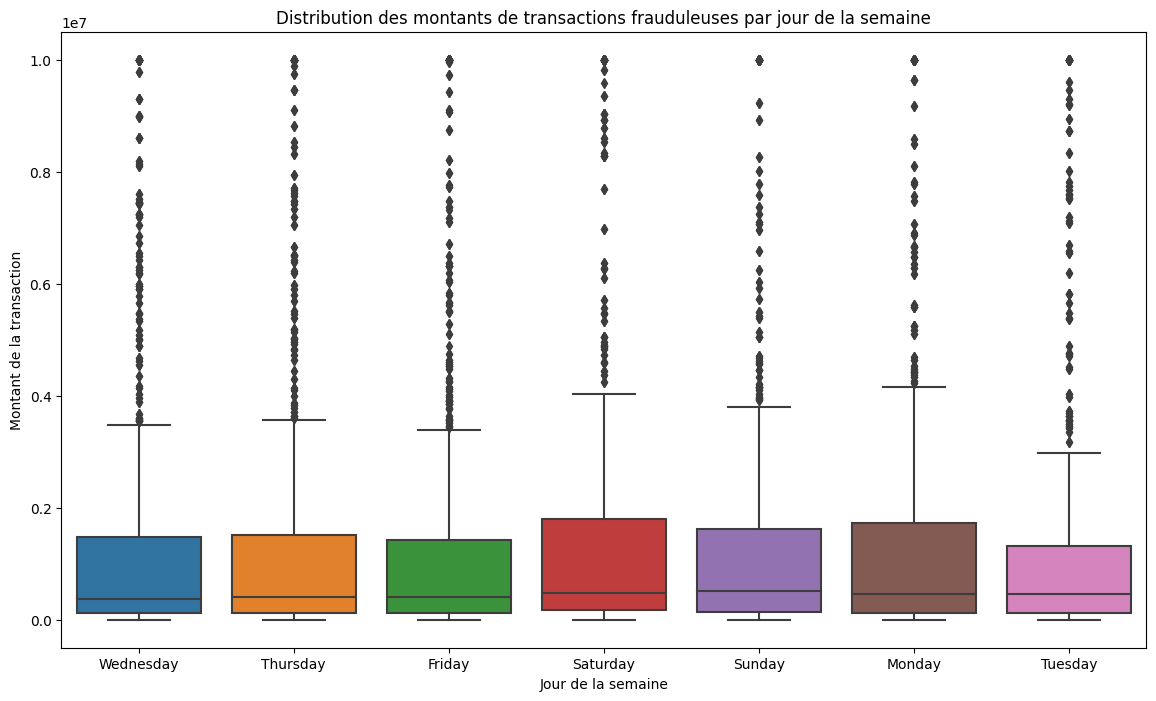

In [102]:
# Distribution des montants de transactions frauduleuses par jour de la semaine avec visualisation graphique
plt.figure(figsize=(14, 8))
sns.boxplot(x='jour_de_la_semaine', y='amount', data=fraudulent_transactions)
plt.title('Distribution des montants de transactions frauduleuses par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Montant de la transaction')
plt.show()


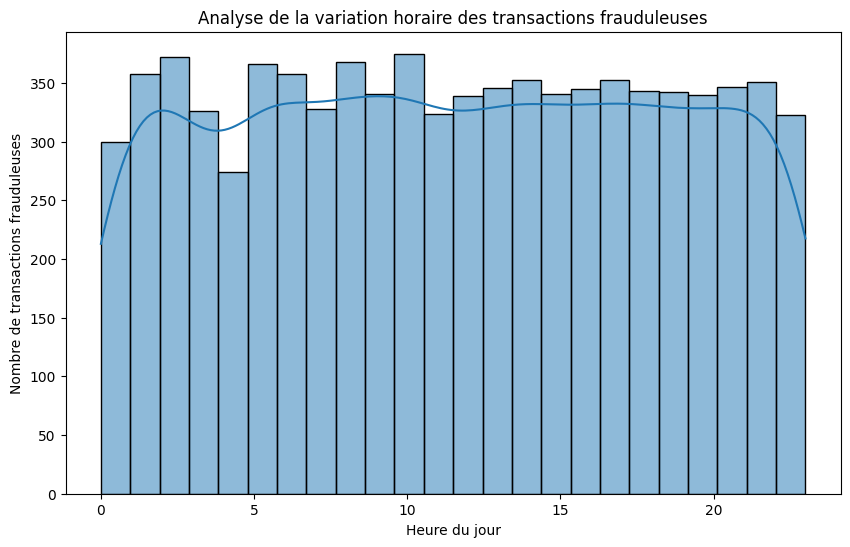

In [62]:
# Analyse de la variation horaire des transactions frauduleuses 
fraudulent_hours = fraudulent_transactions['timestamp'].dt.hour
plt.figure(figsize=(10, 6))
sns.histplot(fraudulent_hours, bins=24, kde=True)
plt.title('Analyse de la variation horaire des transactions frauduleuses')
plt.xlabel('Heure du jour')
plt.ylabel('Nombre de transactions frauduleuses')
plt.show()


C:\Users\a902744\AppData\Local\Temp\ipykernel_40724\2752926375.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='type', y='amount', data=data, hue='isFraud', ci=None)


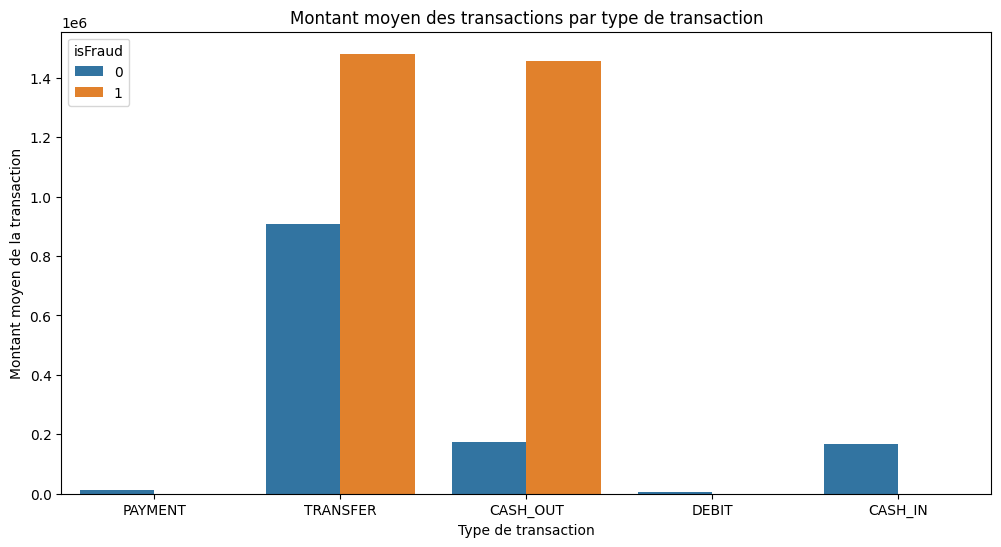

In [63]:
#Montant moyen des transactions par type de transaction 
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='amount', data=data, hue='isFraud', ci=None)
plt.title('Montant moyen des transactions par type de transaction')
plt.xlabel('Type de transaction')
plt.ylabel('Montant moyen de la transaction')
plt.show()


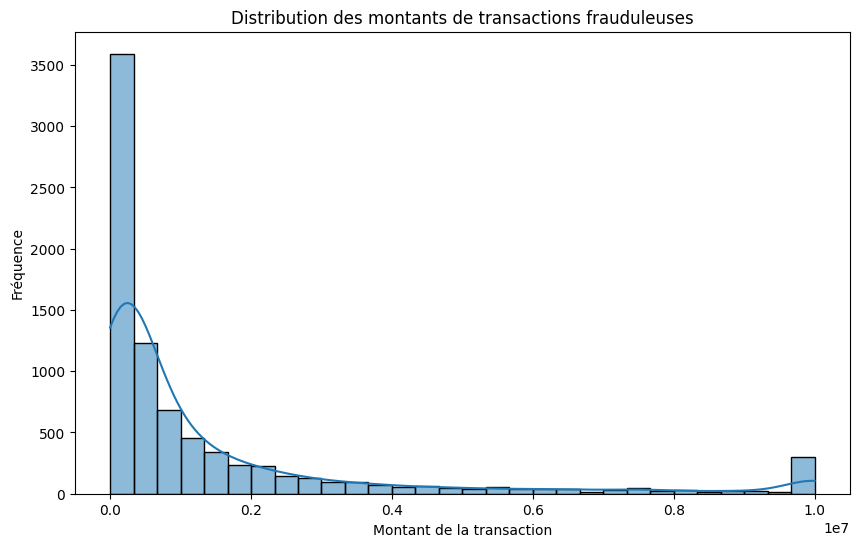

In [103]:
#  Histogramme des montants de transactions frauduleuses avec visualisation graphique
plt.figure(figsize=(10, 6))
sns.histplot(fraudulent_transactions['amount'], bins=30, kde=True)
plt.title('Distribution des montants de transactions frauduleuses')
plt.xlabel('Montant de la transaction')
plt.ylabel('Fréquence')
plt.show()


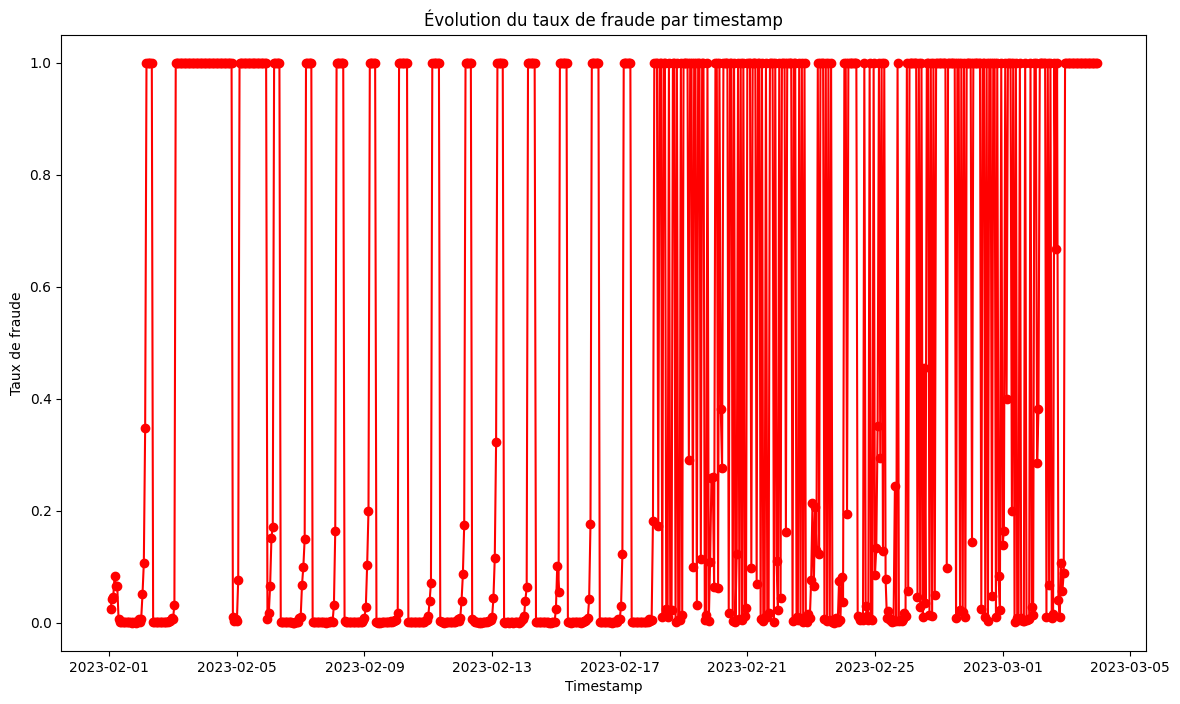

In [104]:
import matplotlib.pyplot as plt

#  'timestamp' est au format datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Calculer le taux de fraude par heure
fraud_rate_by_hour = data.groupby('timestamp')['isFraud'].mean()

# KPI : Évolution du taux de fraude par timestamp avec visualisation graphique
plt.figure(figsize=(14, 8))
plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker='o', linestyle='-', color='r')
plt.title('Évolution du taux de fraude par timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Taux de fraude')
plt.show()


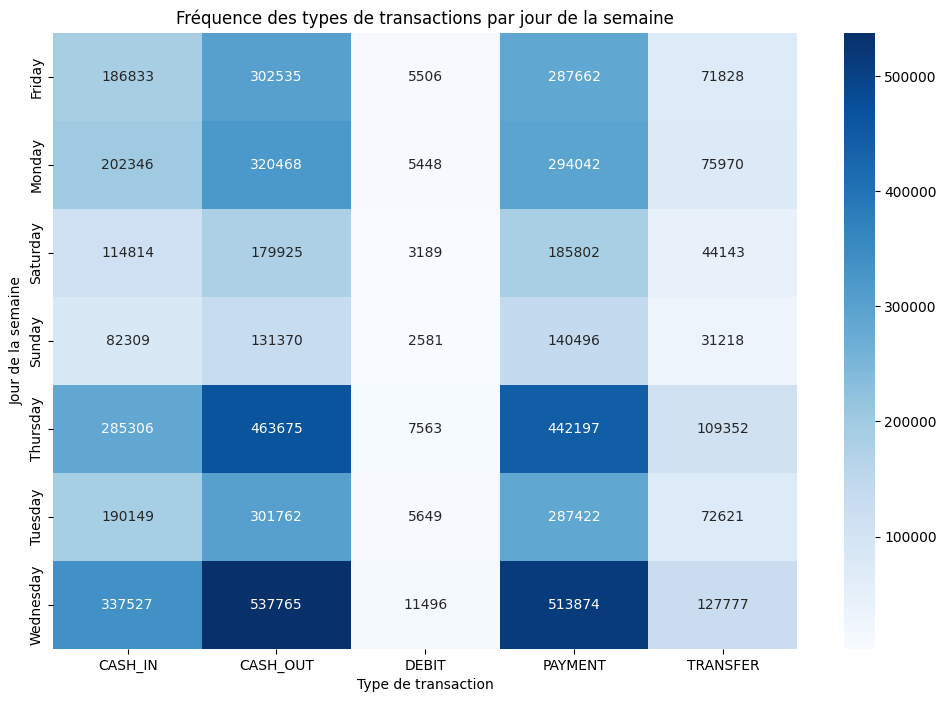

In [66]:
# Heatmap de la fréquence des types de transactions par jour de la semaine avec visualisation graphique
transaction_types_by_weekday = data.groupby(['jour_de_la_semaine', 'type']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(transaction_types_by_weekday, cmap='Blues', annot=True, fmt='d')
plt.title('Fréquence des types de transactions par jour de la semaine')
plt.xlabel('Type de transaction')
plt.ylabel('Jour de la semaine')
plt.show()


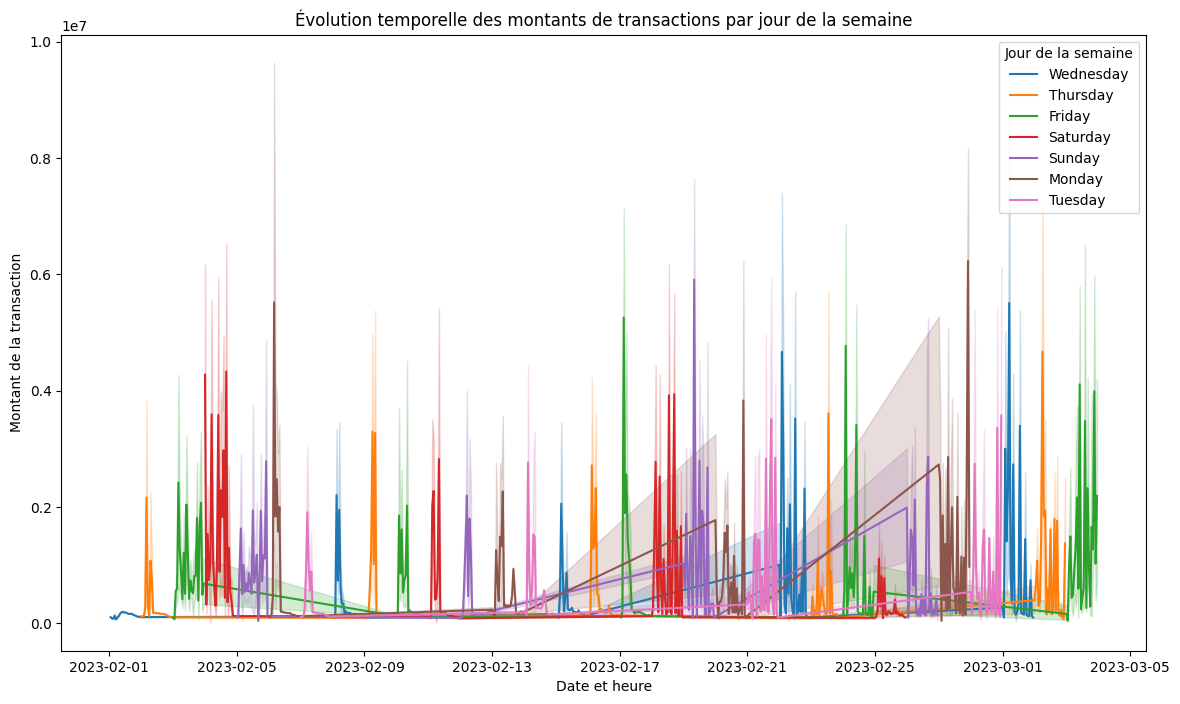

In [67]:
# Évolution temporelle des montants de transactions par jour de la semaine avec visualisation graphique
plt.figure(figsize=(14, 8))
sns.lineplot(x='timestamp', y='amount', hue='jour_de_la_semaine', data=data)
plt.title('Évolution temporelle des montants de transactions par jour de la semaine')
plt.xlabel('Date et heure')
plt.ylabel('Montant de la transaction')
plt.legend(title='Jour de la semaine')
plt.show()


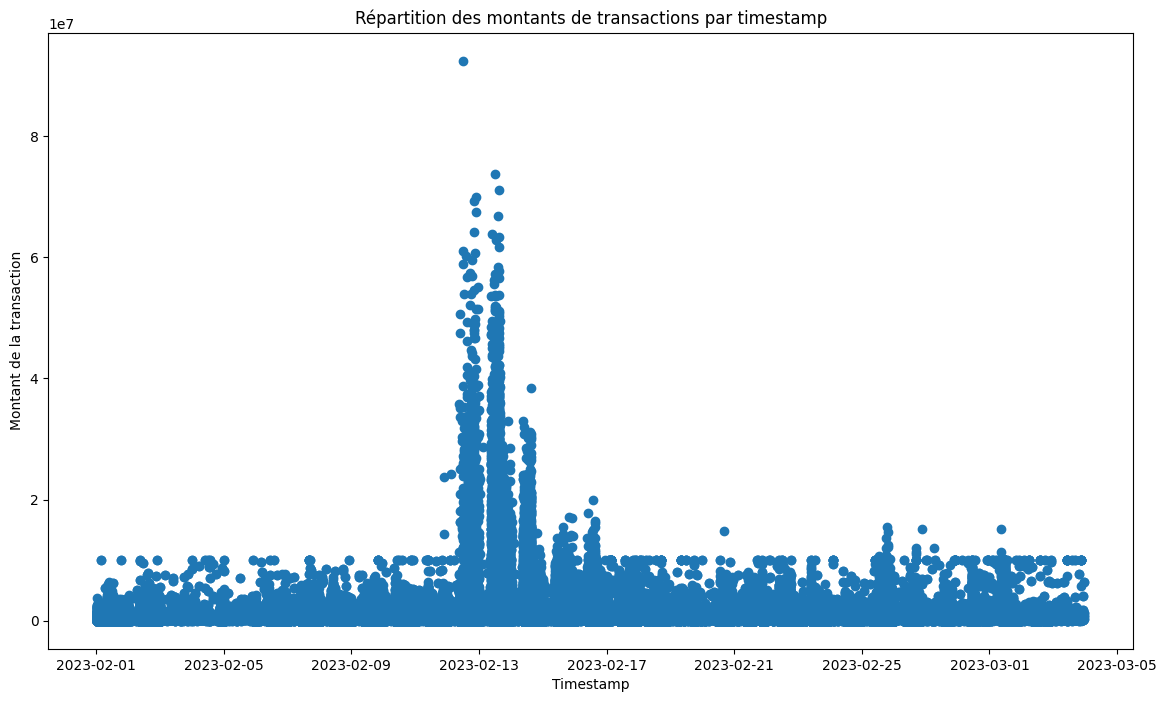

In [105]:
#Répartition des montants de transactions par timestamp avec visualisation graphique
plt.figure(figsize=(14, 8))
fig1 = plt.scatter(data['timestamp'], data['amount'])
#fig2 = px.scatter(data, x="timestamp", y="amount")
plt.title('Répartition des montants de transactions par timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Montant de la transaction')
plt.show()


In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile

##  Exécution des différents KPI avec duckdb

In [ ]:
import duckdb
duckdb.query("SELECT nameDest, amount FROM df where oldbalanceDest == 0.0").to_df()

In [ ]:
#spécifier l'axe des x et l'axe des y
ax = df['isFraud'].value_counts().plot(
kind='pie', # Pour créer un graphique circulaire avec matplotlib,vous pouvez utiliser la fonction 'pie'
figsize=(8,4),# déterminer la taille du graphique
autopct = '%.2f%%', 
labels=df['isFraud'].value_counts().index, #Fournir les étiquettes pour chaque type de TRANACTION 
legend = True,
)

ax.set_title(
'Distributions des transactions fauduleuse et non frauduleuse', # Titre du graphique
loc ='center', # Positionner au centre
fontsize=12, # Dimension du texte
fontweight='bold' # type de caractere
)

plt.show()

In [ ]:
# les client qui font des transaction massive de compte en comme 

Client_trans_massive  = duckdb.query("select nameOrig , amount from df where isFlaggedFraud == 1").to_df()
Client_trans_massive

In [ ]:
Client_trans_massive.max()

In [ ]:
rentabilité_transaction = duckdb.sql("""SELECT 
    type,
    sum(amount) AS montant_moyen_type_transaction
FROM df
GROUP BY type""").to_df()
rentabilité_transaction


In [ ]:
(df["isFlaggedFraud"] == 1).sum()

In [ ]:
(df["isFraud"]==1).sum()

In [ ]:
df.columns

In [ ]:
pourcentage_massive_fraude  = duckdb.sql("""
    SELECT nameOrig, amount , isFraud
    FROM df
    WHERE isFraud = 1 AND isFlaggedFraud = 1
""").to_df()

pourcentage_massive_fraude['isFraud'].sum()

In [ ]:
taux_de_fraud = duckdb.sql("""
    SELECT COUNT(*) AS total_transactions,
           SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS total_fraudulent_transactions,
           (SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(*) AS fraud_rate
    FROM df
""").to_df()

taux_de_fraud


In [ ]:
taux_succe_transfer = duckdb.sql( """
    SELECT COUNT(*) AS total_transfers,
           SUM(CASE WHEN type = 'TRANSFER' THEN 1 ELSE 0 END) AS successful_transfers,
           (SUM(CASE WHEN type = 'TRANSFER' THEN 1 ELSE 0 END) * 100.0) / COUNT(*) AS success_transfer_rate
    FROM df
"""
).to_df()

taux_succe_transfer

In [ ]:
# Impact des transaction frauduleuse 
fraudulent_transactions_impact_query = duckdb.sql("""
    SELECT SUM(amount) AS total_amount_fraudulent_transactions
    FROM df
    WHERE isFraud = 1
""").to_df()

fraudulent_transactions_impact_query


##### Taux de Succès des Transfert

In [ ]:
taux_succé_transfer = duckdb.sql("""SELECT 
    SUM(CASE WHEN type = 'TRANSFER' THEN 1 ELSE 0 END) * 100.0 / COUNT(*) AS success_transfer_rate
FROM df""").to_df()

taux_succé_transfer


##### Taux de Signalement des Transactions Massives 

In [ ]:
taux_signalisation_transaction_massive =  duckdb.sql("""SELECT 
    round(SUM(CASE WHEN amount > 200000 THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2) AS flagged_transactions_rate
FROM df""").to_df()

taux_signalisation_transaction_massive


##### Ratio de Fraude par Type de Transaction 

In [ ]:
fraud_par_type_transaction= duckdb.sql("""SELECT 
    type,
    round(SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100/ COUNT(*),3) AS fraud_ratio_by_type
FROM df
GROUP BY type""").to_df()

fraud_par_type_transaction


In [ ]:
duckdb.sql("""SELECT 
    type,
    COUNT(*) AS nombre_transactions,
    round(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pourcentage_total
FROM df
GROUP BY type
""").to_df()

In [ ]:
df.shape

In [ ]:
print('CASH_OUT', round(df['type'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('PAYMENT', round(df['type'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('CASH_IN', round(df['type'].value_counts()[2]/len(df) * 100,2), '% of the dataset')
print('TRANSFER', round(df['type'].value_counts()[3]/len(df) * 100,2), '% of the dataset')
print('DEBIT', round(df['type'].value_counts()[4]/len(df) * 100,2), '% of the dataset')


#####   Fréquence des Transactions par Client :


In [ ]:
frequence_transaction_client = duckdb.sql("""SELECT 
    nameOrig,
    COUNT(*) AS transaction_count_per_client,
    (COUNT(*) * 1.0) / (SELECT COUNT(*) FROM df) AS frequency
FROM df
GROUP BY nameOrig
""").to_df()
frequence_transaction_client['transaction_count_per_client'].unique()

#### Évolution du Solde Moyen des Comptes Clients

In [ ]:
evolution_solde_moyen_compte_client = duckdb.sql("""SELECT 
    nameOrig,
    AVG(newbalanceOrig - oldbalanceOrg) AS average_balance_change
FROM df
GROUP BY nameOrig
""").to_df()

evolution_solde_moyen_compte_client.shape

In [ ]:
print(df['isFraud'].value_counts()[0]/len(df) * 100,2)
print(df['isFraud'].value_counts()[1]/len(df) * 100,2)

In [ ]:
df['type'].value_counts()

In [ ]:
var_catégorielle = ['type', 'nameOrig', 'nameDest']

colonnes_existantes = df.columns.tolist()
colonnes_a_supprimer = [colonne for colonne in var_catégorielle if colonne in colonnes_existantes]

df_num = df.drop(columns=colonnes_a_supprimer)
df_num

## Conservation des observations ou type = transfer ou cash_out 

In [107]:
data1 = dt.query('type == "TRANSFER" or type == "CASH_OUT"')
data1['type'].unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [108]:
fraud_data = df[df['isFraud'] ==1]


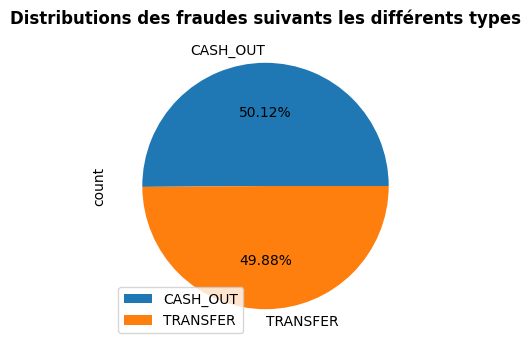

In [109]:
#spécifier l'axe des x et l'axe des y
ax = fraud_data['type'].value_counts().plot(
kind='pie', 
figsize=(8,4),
autopct = '%.2f%%', 
labels=fraud_data['type'].value_counts().index,
legend = True,
)

ax.set_title(
'Distributions des fraudes suivants les différents types', 
loc ='center',
fontsize=12, 
fontweight='bold'
)

plt.show()

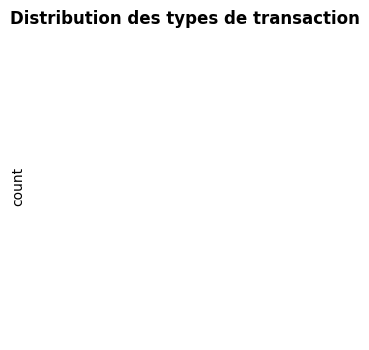

In [110]:
#spécifier l'axe des x et l'axe des y
ax = data['type'].value_counts().plot(
kind='pie', 
figsize=(8,4),
autopct = '%.2f%%', 
labels=df['type'].value_counts().index,
legend = True,
)

ax.set_title(
'Distribution des types de transaction', 
loc ='center',
fontsize=12, 
fontweight='bold'
)

plt.show()

In [ ]:
# Distribution des transactions frauduleuse suivant les différents type 

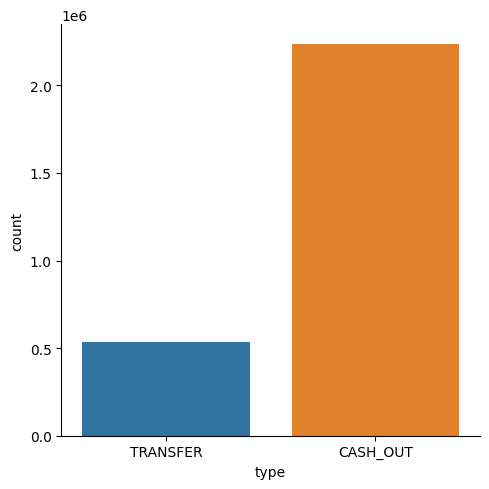

In [72]:
# to each gender 
sns.catplot(x='type', kind='count', data=data) 


In [112]:
var_catégorielle = ['nameOrig', 'nameDest']

colonnes_existantes = data1.columns.tolist()
colonnes_a_supprimer = [colonne for colonne in var_catégorielle if colonne in colonnes_existantes]

data = data1.drop(columns=colonnes_a_supprimer)
data.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

In [113]:
# Let's turn non-numerical values into numbers
for label, content in data.items():
    if not pd.api.types.is_numeric_dtype(content):
        data[label] = pd.Categorical(content).codes+1

data.shape


(2770409, 9)

### Distribution  de fraude suivant type transfer ou cash_out 

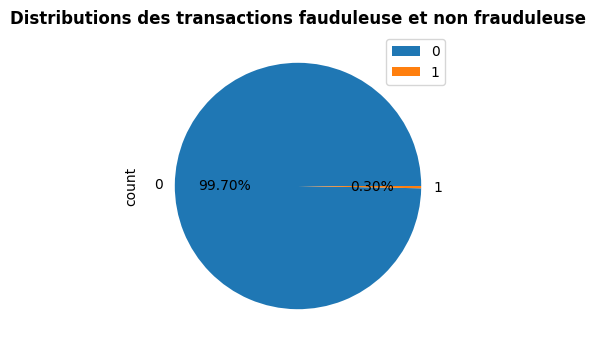

In [114]:
#spécifier l'axe des x et l'axe des y
ax = data['isFraud'].value_counts().plot(
kind='pie', 
figsize=(8,4),
autopct = '%.2f%%', 
labels=df['isFraud'].value_counts().index,
legend = True,
)

ax.set_title(
'Distributions des transactions fauduleuse et non frauduleuse', 
loc ='center',
fontsize=12, 
fontweight='bold'
)

plt.show()

En analysant les résultats obtenus à partir de la matrice de corrélation, on observe que 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest' présentent une corrélation très élevée (corrélation de 1). Afin d'éviter la multicollinéarité  (La multicollinéarité est un terme utilisé en statistiques et en analyse de régression pour décrire une situation où deux ou plusieurs variables indépendantes dans un modèle statistique sont fortement corrélées entre elles) dans le modèle, il est possible de supprimer l'une des variables, d'appliquer l'Analyse en Composantes Principales (ACP) ou encore d'étudier la contribution de chaque variable en fonction du modèle

In [115]:
# Utilisons loption suprresion des l'un des variable

var_catégorielle = [ 'oldbalanceOrg', 'newbalanceDest']

colonnes_existantes = data.columns.tolist()
colonnes_a_supprimer = [colonne for colonne in var_catégorielle if colonne in colonnes_existantes]

data_model = data.drop(columns=colonnes_a_supprimer)
data_model .columns

Index(['step', 'type', 'amount', 'newbalanceOrig', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Text des modèles de Machine Learning 

In [116]:
X = data_model.drop('isFraud', axis=1)
y = data_model['isFraud']

In [117]:
X.columns

Index(['step', 'type', 'amount', 'newbalanceOrig', 'oldbalanceDest',
       'isFlaggedFraud'],
      dtype='object')

In [118]:
np.random.seed(37)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Random Forest 

In [119]:
from sklearn.preprocessing import RobustScaler
sc=RobustScaler()
X_train=sc.fit_transform(X_train)
X_test= sc.fit_transform(X_test)

In [120]:
#Definition du modèle
R1=RandomForestClassifier(40)
R1.fit(X_train,y_train)
#Prediction et affichage de la matrice de confusion
pred1 = R1.predict(X_train)
c_train = confusion_matrix(y_train, pred1)
pred = R1.predict(X_test)
c_test = confusion_matrix(y_test, pred)

In [127]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train, pred1)
test_accuracy = roc_auc_score(y_test, pred)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.9919985659957786
test accurency 0.6157779983981231


Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2209702          1    552473        20
y=1        106       6518      1221       368 


[[2209702       1]
 [    106    6518]]


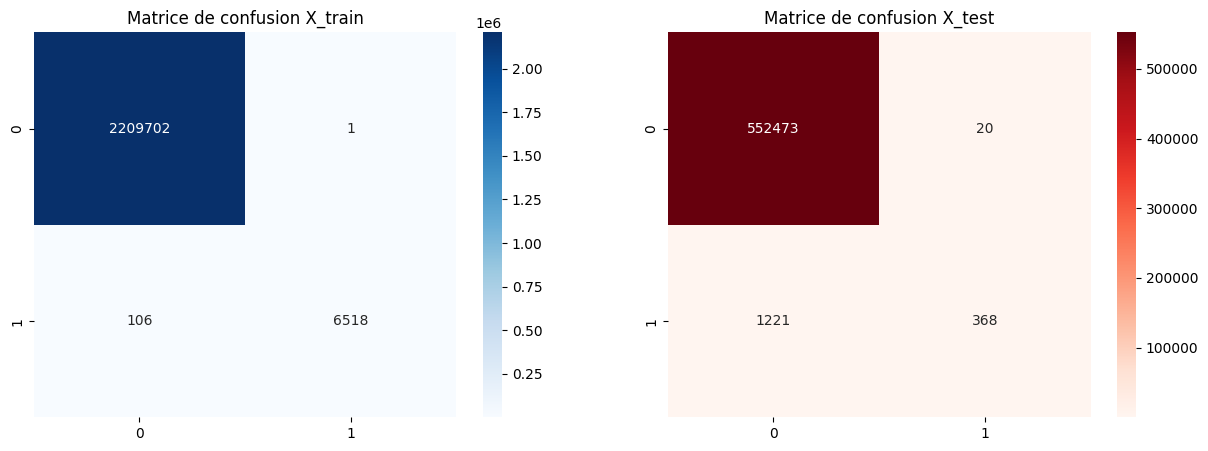

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552493
           1       0.95      0.23      0.37      1589

    accuracy                           1.00    554082
   macro avg       0.97      0.62      0.69    554082
weighted avg       1.00      1.00      1.00    554082



<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [128]:
#Affichage
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")
print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')
plt.title('Matrice de confusion X_train')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.title('Matrice de confusion X_test')

plt.show()
print(classification_report(y_test, pred))
sns.heatmap

#### Test avec un model ensembliste : XGBClassifier 

In [129]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [130]:
#Definition du modèle
model = XGBClassifier()
model.fit(X_train,y_train)
#Prediction et affichage de la matrice de confusion
predict_train = model.predict(X_train)
c_train = confusion_matrix(y_train, predict_train)
predict_test = model.predict(X_test)
c_test = confusion_matrix(y_test, predict_test)

In [133]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train, predict_train)
test_accuracy = roc_auc_score(y_test, predict_test)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.6850207315825234
test accurency 0.6742402149095283


Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2209421        282    552401        92
y=1       4172       2452      1035       554 


[[2209421     282]
 [   4172    2452]]


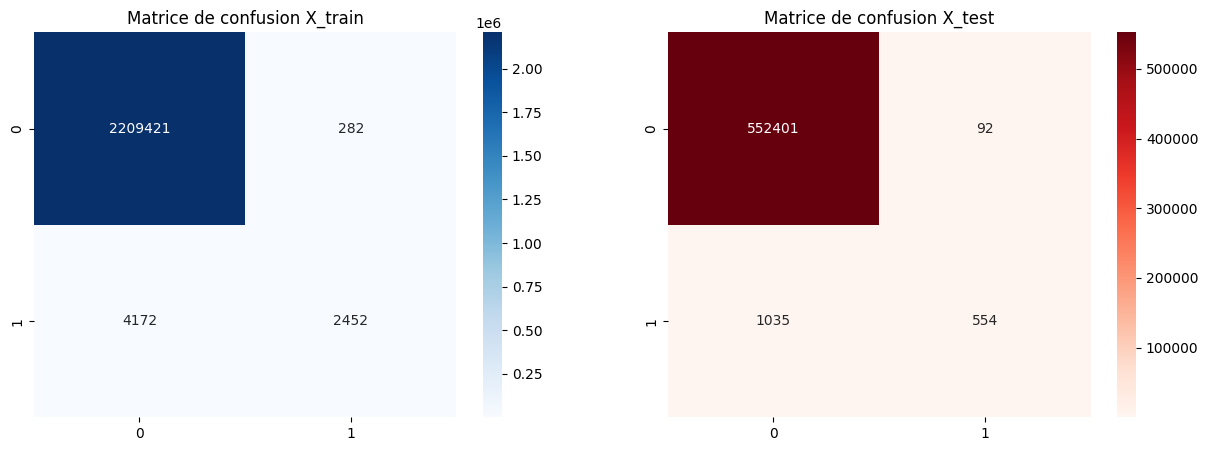

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552493
           1       0.86      0.35      0.50      1589

    accuracy                           1.00    554082
   macro avg       0.93      0.67      0.75    554082
weighted avg       1.00      1.00      1.00    554082



<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [134]:
#Affichage
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")
print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')
plt.title('Matrice de confusion X_train')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.title('Matrice de confusion X_test')

plt.show()
print(classification_report(y_test, predict_test))
sns.heatmap

###  deep Learning Model 

In [135]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])






Epoch 1/10


55409/55409 [==============================] - 449s 8ms/step - loss: 151.8745 - accuracy: 0.9963 - val_loss: 0.1361 - val_accuracy: 0.9969
Epoch 2/10
55409/55409 [==============================] - 451s 8ms/step - loss: 7.1306 - accuracy: 0.9963 - val_loss: 0.1260 - val_accuracy: 0.9971
Epoch 3/10
55409/55409 [==============================] - 396s 7ms/step - loss: 1.6139 - accuracy: 0.9969 - val_loss: 0.0150 - val_accuracy: 0.9972
Epoch 4/10
55409/55409 [==============================] - 329s 6ms/step - loss: 5.4172 - accuracy: 0.9971 - val_loss: 0.0148 - val_accuracy: 0.9973
Epoch 5/10
55409/55409 [==============================] - 480s 9ms/step - loss: 2.6080 - accuracy: 0.9972 - val_loss: 0.0161 - val_accuracy: 0.9972
Epoch 6/10
55409/55409 [==============================] - 262s 5ms/step - loss: 2.2786 - accuracy: 0.9972 - val_loss: 0.0145 - val_accuracy: 0.9972
Epoch 7/10
55409/55409 [==============================] - 414s 7ms/step - loss: 2.8624 - accuracy: 0.9972

In [136]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


17316/17316 [==============================] - 38s 2ms/step - loss: 0.0132 - accuracy: 0.9975
Test Accuracy: 0.9975491166114807


17316/17316 [==============================] - 38s 2ms/step
Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2209681         22    552491         2
y=1       5704        920      1356       233 


[[2209681      22]
 [   5704     920]]


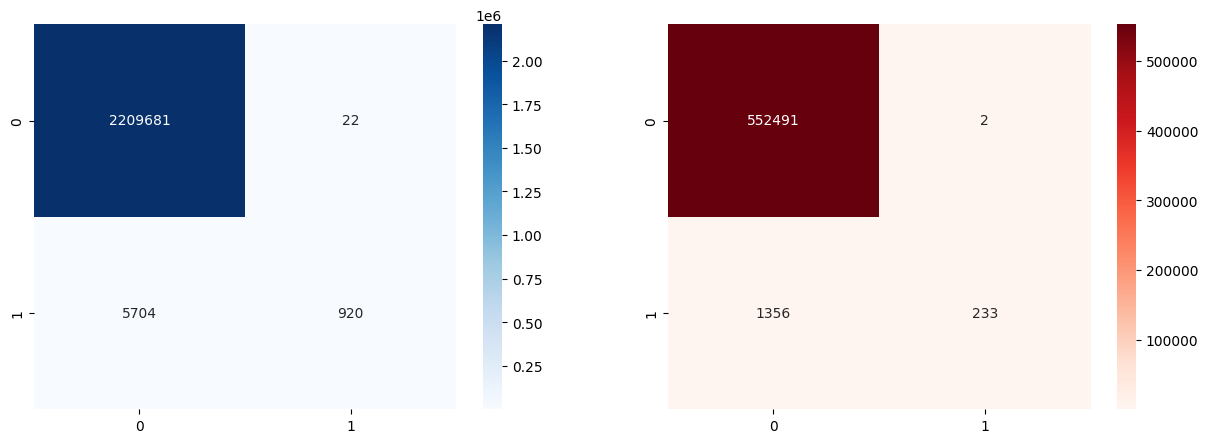

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552493
           1       0.99      0.15      0.26      1589

    accuracy                           1.00    554082
   macro avg       0.99      0.57      0.63    554082
weighted avg       1.00      1.00      1.00    554082



In [143]:

pred1 = (model.predict(X_train)> 0.5).astype("int32")
c_train = confusion_matrix(y_train, pred1)
pred = (model.predict(X_test)> 0.5).astype("int32")
c_test = confusion_matrix(y_test, pred)
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")


print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.show()
print(classification_report(y_test, pred))
sns.heatmap
plt.show()

In [144]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train, pred1)
test_accuracy = roc_auc_score(y_test, pred)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.5694394663998836
test accurency 0.5733147413124366


# Sous-echantillonage
<a id="18"></a>


Dans cette partie nous essayons d'équilibrer les données de notre variable cible 'Class'. On utilisons Ainsi la méthode du sous-échantillonnage aléatoire ou 'Under-Sampling aléatoire L'objectif ici est de supprimer aléatoirement certaines observations de la classe majoritaire et de répéter l'opération jusqu'à ce que la classe majoritaire et minoritaire soit équilibrée.

Le sous-échantillonnage peut être un bon choix lorsque nos donnéessont de taille importante. Mais son inconvénient est que parfois nous supprimons les informations qui peuvent être précieuses.

In [145]:
from imblearn.under_sampling import RandomUnderSampler
sample=RandomUnderSampler()
X_train_samp, y_train_samp=sample.fit_resample(X_train,y_train )


### Random Forest

In [146]:
#Definition du modèle
R1=RandomForestClassifier(40)
R1.fit(X_train_samp, y_train_samp)
#Prediction et affichage de la matrice de confusion
pred1 = R1.predict(X_train_samp)
c_train = confusion_matrix(y_train_samp, pred1)
pred = R1.predict(X_test)
c_test = confusion_matrix(y_test, pred)

In [149]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train_samp, pred1)
test_accuracy = roc_auc_score(y_test, pred)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.9991696859903382
test accurency 0.7987998946959768


Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0       6623          1    522447     30046
y=1         10       6614       553      1036 


[[6623    1]
 [  10 6614]]


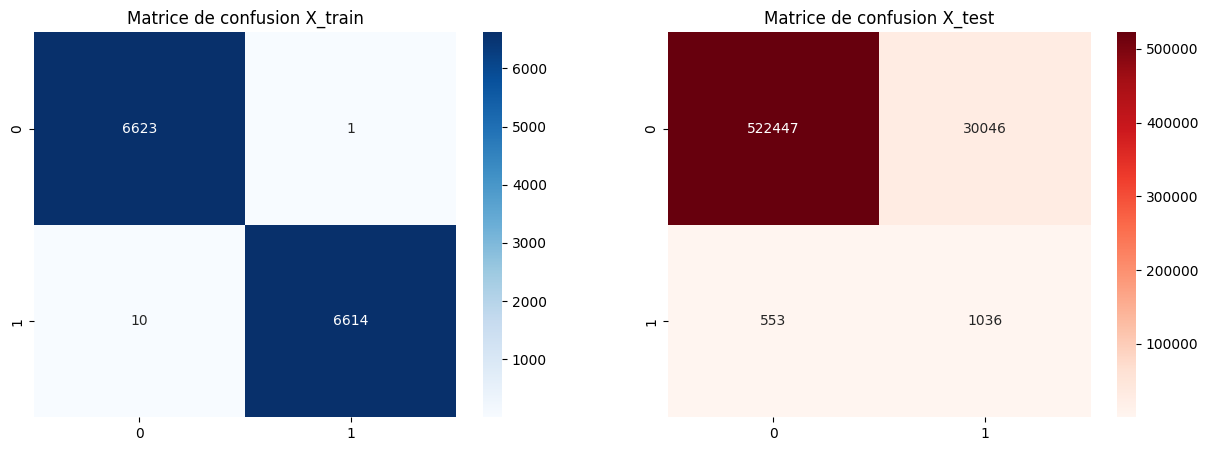

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    552493
           1       0.03      0.65      0.06      1589

    accuracy                           0.94    554082
   macro avg       0.52      0.80      0.52    554082
weighted avg       1.00      0.94      0.97    554082



<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [150]:
#Affichage
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")
print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')
plt.title('Matrice de confusion X_train')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.title('Matrice de confusion X_test')

plt.show()
print(classification_report(y_test, pred))
sns.heatmap

#### XGBCLASSIER

In [160]:
#Definition du modèle
model = XGBClassifier()
model.fit(X_train_samp,y_train_samp)
#Prediction et affichage de la matrice de confusion
predict_train = model.predict(X_train_samp)
c_train = confusion_matrix(y_train_samp, predict_train)
predict_test = model.predict(X_test)
c_test = confusion_matrix(y_test, predict_test)

In [162]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train_samp, predict_train)
test_accuracy = roc_auc_score(y_test, predict_test)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.9557614756372237
test accurency 0.9077738800052024


Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2117909      91794    529512     22981
y=1     103714    2105989       227      1362 


[[2117909   91794]
 [ 103714 2105989]]


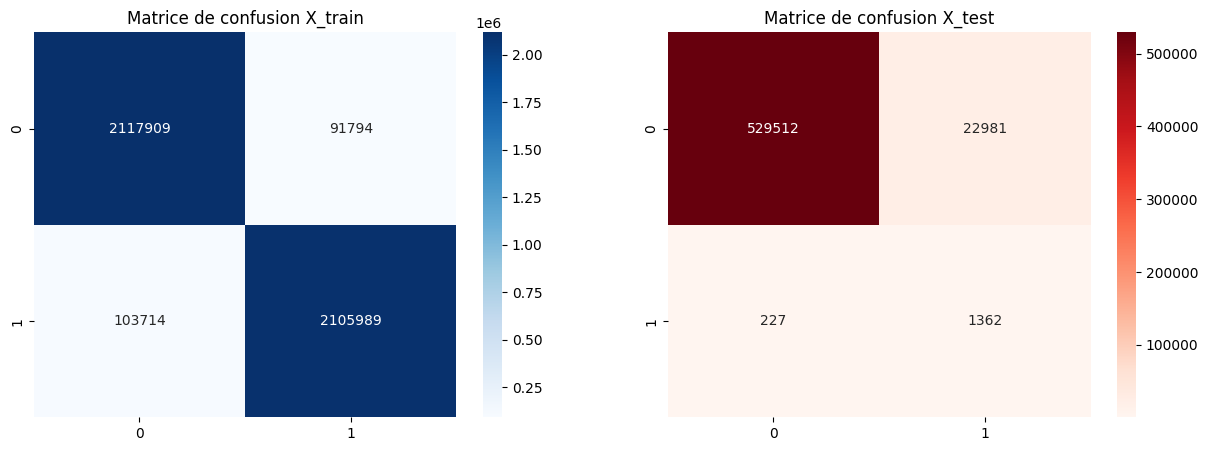

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    552493
           1       0.06      0.86      0.11      1589

    accuracy                           0.96    554082
   macro avg       0.53      0.91      0.54    554082
weighted avg       1.00      0.96      0.98    554082



<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [163]:
#Affichage
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")
print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')
plt.title('Matrice de confusion X_train')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.title('Matrice de confusion X_test')

plt.show()
print(classification_report(y_test, predict_test))
sns.heatmap

### Deep Learning Model

In [167]:

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_samp, y_train_samp, epochs=10, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
110486/110486 [==============================] - 507s 5ms/step - loss: 50.3402 - accuracy: 0.8717 - val_loss: 0.4310 - val_accuracy: 0.7921
Epoch 2/10
110486/110486 [==============================] - 441s 4ms/step - loss: 11.6360 - accuracy: 0.8792 - val_loss: 0.4168 - val_accuracy: 0.7944
Epoch 3/10
110486/110486 [==============================] - 428s 4ms/step - loss: 5.4432 - accuracy: 0.8796 - val_loss: 0.4653 - val_accuracy: 0.7695
Epoch 4/10
110486/110486 [==============================] - 665s 6ms/step - loss: 0.6584 - accuracy: 0.8824 - val_loss: 0.4370 - val_accuracy: 0.7956
Epoch 5/10
110486/110486 [==============================] - 395s 4ms/step - loss: 0.4187 - accuracy: 0.8838 - val_loss: 0.4541 - val_accuracy: 0.7865


17316/17316 [==============================] - 31s 2ms/step
Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2100116     109587    525288     27205
y=1     471912    1737791       326      1263 


[[2100116  109587]
 [ 471912 1737791]]


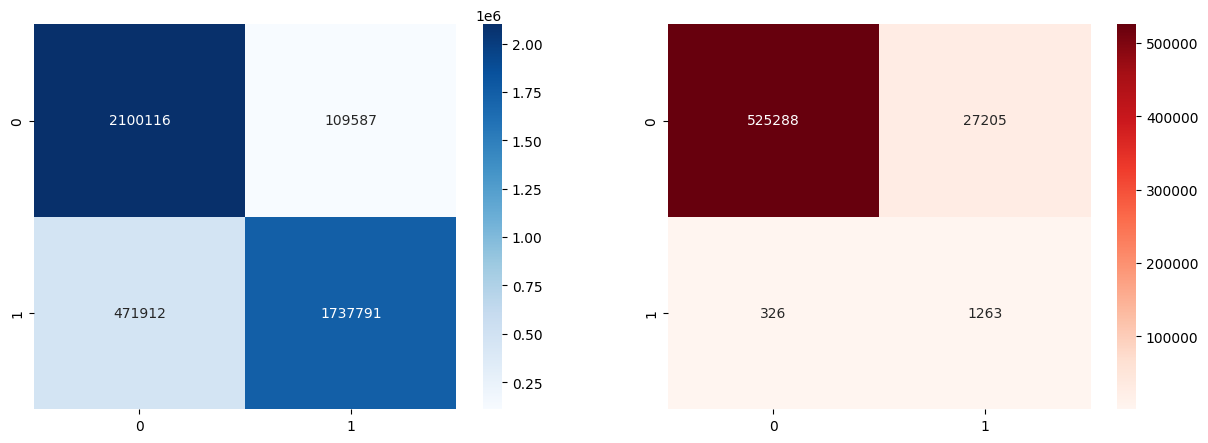

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    552493
           1       0.04      0.79      0.08      1589

    accuracy                           0.95    554082
   macro avg       0.52      0.87      0.53    554082
weighted avg       1.00      0.95      0.97    554082



In [170]:

pred1 = (model.predict(X_train_samp)> 0.5).astype("int32")
c_train = confusion_matrix(y_train_samp, pred1)
pred = (model.predict(X_test)> 0.5).astype("int32")
c_test = confusion_matrix(y_test, pred)
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")


print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.show()
print(classification_report(y_test, pred))
sns.heatmap
plt.show()

In [171]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train_samp, pred1)
test_accuracy = roc_auc_score(y_test, pred)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.8684214575442945
test accurency 0.8727995394232145


## OverSampling 

In [155]:
from imblearn.over_sampling import RandomOverSampler
sample=RandomOverSampler()
X_train_sampOver, y_train_sampOver = sample.fit_resample(X_train, y_train)
X_train_sampOver.shape, y_train_sampOver.shape

((4419406, 6), (4419406,))

In [156]:
#Definition du modèle
R1=RandomForestClassifier(40)
R1.fit(X_train_sampOver, y_train_sampOver)
#Prediction et affichage de la matrice de confusion
pred1 = R1.predict(X_train_sampOver)
c_train = confusion_matrix(y_train_sampOver, pred1)
pred = R1.predict(X_test)
c_test = confusion_matrix(y_test, pred)

In [158]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train_sampOver, pred1)
test_accuracy = roc_auc_score(y_test, pred)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.9999993211757416
test accurency 0.6044247795412726


Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2209700          3    552445        48
y=1          0    2209703      1257       332 


[[2209700       3]
 [      0 2209703]]


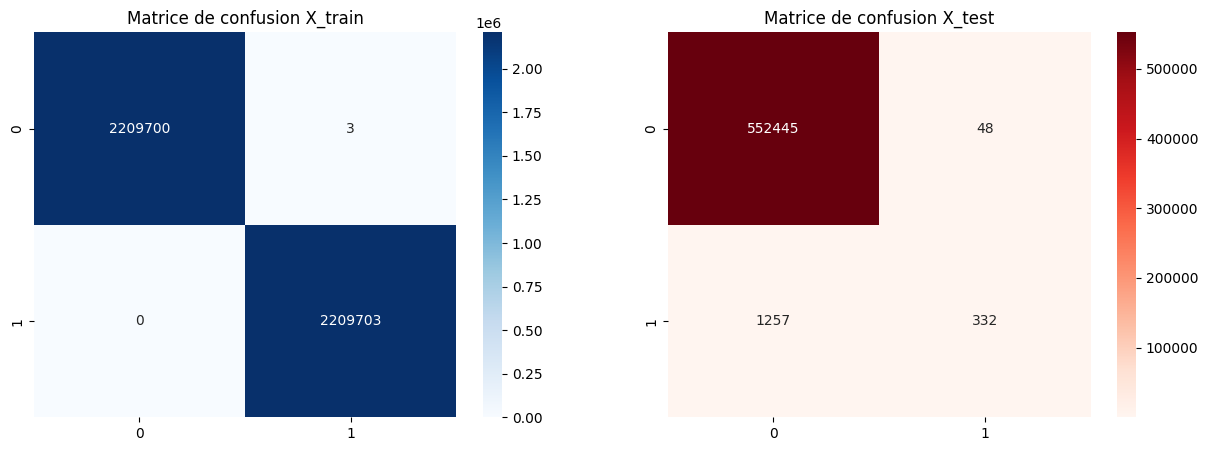

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552493
           1       0.87      0.21      0.34      1589

    accuracy                           1.00    554082
   macro avg       0.94      0.60      0.67    554082
weighted avg       1.00      1.00      1.00    554082



<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [159]:
#Affichage
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")
print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')
plt.title('Matrice de confusion X_train')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.title('Matrice de confusion X_test')

plt.show()
print(classification_report(y_test, pred))
sns.heatmap

### XGBCLASSIER

In [164]:
#Definition du modèle
model = XGBClassifier()
model.fit(X_train_sampOver,y_train_sampOver)
#Prediction et affichage de la matrice de confusion
predict_train = model.predict(X_train_sampOver)
c_train = confusion_matrix(y_train_sampOver, predict_train)
predict_test = model.predict(X_test)
c_test = confusion_matrix(y_test, predict_test)

In [165]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train_sampOver, predict_train)
test_accuracy = roc_auc_score(y_test, predict_test)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.9566837715294771
test accurency 0.9136163751981995


Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2119827      89876    530057     22436
y=1     101556    2108147       210      1379 


[[2119827   89876]
 [ 101556 2108147]]


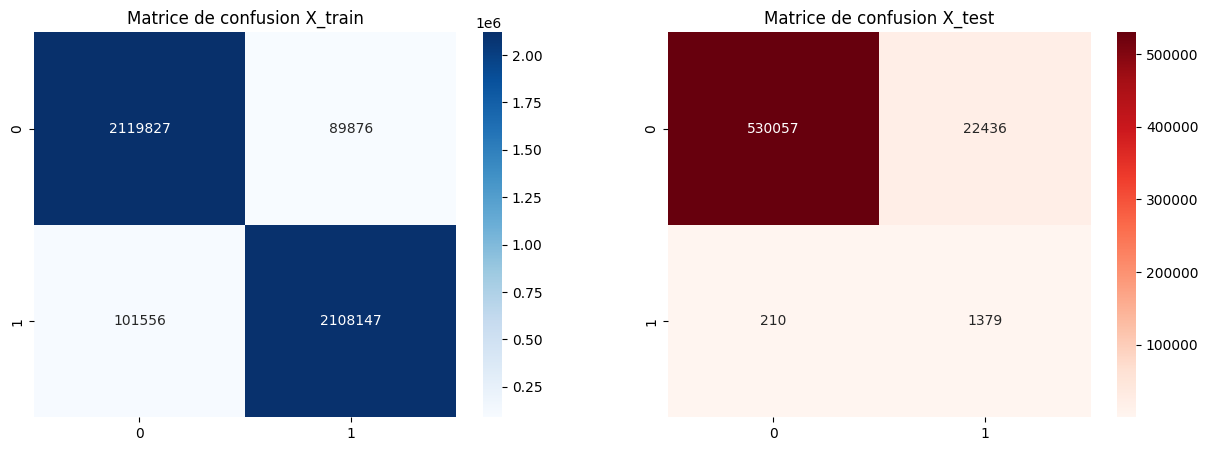

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    552493
           1       0.06      0.87      0.11      1589

    accuracy                           0.96    554082
   macro avg       0.53      0.91      0.54    554082
weighted avg       1.00      0.96      0.98    554082



<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

In [166]:
#Affichage
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")
print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')
plt.title('Matrice de confusion X_train')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.title('Matrice de confusion X_test')

plt.show()
print(classification_report(y_test, predict_test))
sns.heatmap

### Deep Learning Model

In [172]:

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_sampOver,y_train_sampOver, epochs=10, batch_size=32, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
110486/110486 [==============================] - 421s 4ms/step - loss: 51.4572 - accuracy: 0.8704 - val_loss: 0.4543 - val_accuracy: 0.7696
Epoch 2/10
110486/110486 [==============================] - 403s 4ms/step - loss: 6.0747 - accuracy: 0.8797 - val_loss: 0.4117 - val_accuracy: 0.8019
Epoch 3/10
110486/110486 [==============================] - 427s 4ms/step - loss: 2.1320 - accuracy: 0.8814 - val_loss: 0.4450 - val_accuracy: 0.7862
Epoch 4/10
110486/110486 [==============================] - 423s 4ms/step - loss: 0.5028 - accuracy: 0.8837 - val_loss: 0.4293 - val_accuracy: 0.7887
Epoch 5/10
110486/110486 [==============================] - 423s 4ms/step - loss: 0.7275 - accuracy: 0.8846 - val_loss: 0.4206 - val_accuracy: 0.7768


17316/17316 [==============================] - 29s 2ms/step
Confusion Matrix
     train:y=0  train:y=1  test:y=0  test:y=1
y=0    2110400      99303    527757     24736
y=1     493988    1715715       343      1246 


[[2110400   99303]
 [ 493988 1715715]]


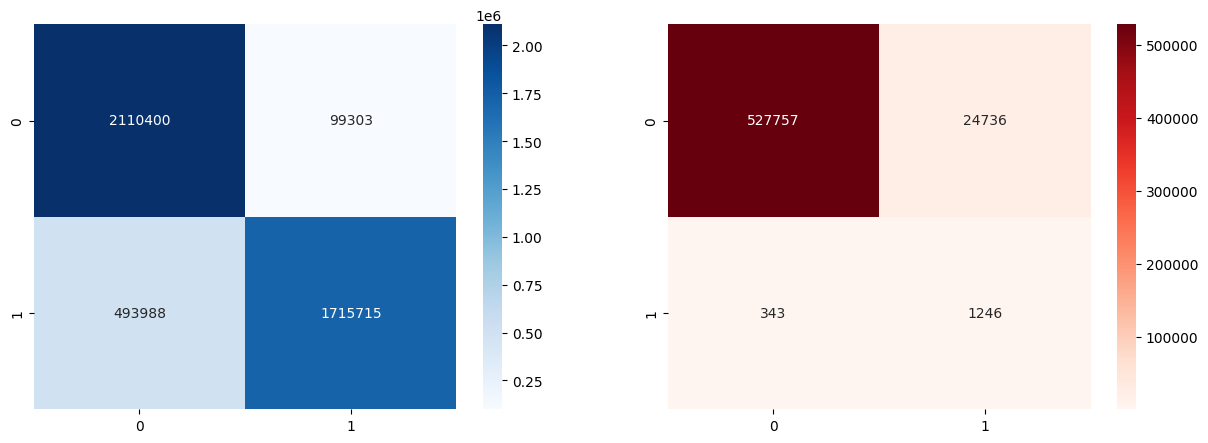

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    552493
           1       0.05      0.78      0.09      1589

    accuracy                           0.95    554082
   macro avg       0.52      0.87      0.53    554082
weighted avg       1.00      0.95      0.97    554082



In [173]:

pred1 = (model.predict(X_train_sampOver)> 0.5).astype("int32")
c_train = confusion_matrix(y_train_sampOver, pred1)
pred = (model.predict(X_test)> 0.5).astype("int32")
c_test = confusion_matrix(y_test, pred)
print("Confusion Matrix")
print(pd.DataFrame(np.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split()), "\n\n")


print(c_train)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(c_train,annot=True,cmap='Blues',fmt='0')

plt.subplot(1,2,2)
sns.heatmap(c_test,annot=True,cmap='Reds',fmt='0',xticklabels='auto',
    yticklabels='auto')
plt.show()
print(classification_report(y_test, pred))
sns.heatmap
plt.show()

In [174]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
# evaluate
train_accuracy = roc_auc_score(y_train_sampOver, pred1)
test_accuracy = roc_auc_score(y_test, pred)
print("train accurency",train_accuracy)
print("test accurency",test_accuracy)


train accurency 0.8657532256597379
test accurency 0.8696846805984608
